# Explore attractor landscapes in SF networks with and without oscillations
# 2/11/18 


In [2]:
import sys
import os

sys.path.append("../classes")

from HomGraph import *
from SFGraph import *
from sighelp import *
from matplotlib.pyplot import cm
from matplotlib.mlab import frange
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import sparse
import scipy as scp
from scipy.sparse import csgraph

import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


from matplotlib import rcParams

sns.set(
    context="paper",
    font_scale=4,
    rc={
        "figure.figsize": (20, 10),
        "legend.frameon": True,
        "legend.loc": "upper right",
    },
)

sns.set_style("white")

Step one.. let's start by making networks with size n = 1000, $\gamma$ = 2.0.  Finding attractors with 4 different periods of oscillation

In [2]:
def record_attractors_to_files():

    n = 1000
    gam = 2.0

    attractor_starts = []
    attractor_lengths = []
    trials = 1000
    misses = 0
    periods = [2.0, 20.0, 100.0]
    str_periods = ("\t").join([str(per) for per in periods])
    t = 4000
    f = open("ScaleFreeAttractorTimes%d%.2f.txt" % (n, gam), "w")
    g = open("ScaleFreeAttractorTimesSmallestCycle%d%.2f.txt" % (n, gam), "w")
    f.write(
        "Scale Free Networks WITH OUTGOING POWER LAW: N = %d, gamma = %.2f\n" % (n, gam)
    )
    f.write("Trial\tControl\t" + str_periods + "\n")
    g.write(
        "Scale Free Networks WITH OUTGOING POWER LAW: N = %d, gamma = %.2f.. SMALLEST Cycle found\n"
        % (n, gam)
    )
    g.write("Trial\tControl\t" + str_periods + "\n")
    for _ in range(trials):
        my_graph = SFGraph(size=n, lam=gam)
        hub = my_graph.find_hub()
        start_config = np.copy(my_graph.get_config())
        temp_storage = []
        temp_smallest_storage = []

        # Control... Blcok the node!
        temp = my_graph.find_cycle(block=True, hub=hub)
        temp_storage.append(temp)
        temp_smallest_storage.append(temp)
        for per in periods:
            # reset start config
            my_graph.set_config(np.copy(start_config))
            osc_table = my_graph.oscillate_update(hub, period=per, time=t)
            temp = Graph.find_attractor_in_oscillations(osc_table, per)
            temp_smallest = Graph.find_attractor(osc_table)
            temp_storage.append(temp)
            temp_smallest_storage.append(temp_smallest)
        str_entry = "\t".join([str(entry) for entry in temp_storage])
        f.write(f"{_}\t" + str_entry + "\n")
        str_entry_smallest = "\t".join([str(entry) for entry in temp_smallest_storage])
        g.write(f"{_}\t" + str_entry_smallest + "\n")
    f.close()
    g.close()


record_attractors_to_files()

Can we plot these distributions? Where we'll have one that uses the shortest attractor found within a period and one that considers attractors as long as the period at minimum

In [9]:
def recover_data():
    f1 = "/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Oscillating Attractors/Quantitative/ScaleFreeAttractorTimesSmallestCycle10002.00.txt"
    f2 = "/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Oscillating Attractors/Quantitative/ScaleFreeAttractorTimes10002.00.txt"

    df_shortest_cycle = pd.read_csv(filepath_or_buffer=f1, sep="\t", header=1)
    df_oscillating_cycle = pd.read_csv(filepath_or_buffer=f2, sep="\t", header=1)

    df_shortest_cycle["InsidePeriodCycles"] = [True] * df_shortest_cycle.shape[0]
    df_oscillating_cycle["InsidePeriodCycles"] = [False] * df_shortest_cycle.shape[0]

    new_df = []
    periods = ["Control", "2.0", "20.0", "100.0"]
    for df in [df_shortest_cycle, df_oscillating_cycle]:
        for index, row in df.iterrows():
            for per in periods:
                # print(eval(test[per]))
                start, finish = eval(row[per])
                attr_size = finish - start
                attr_trans = start
                new_df.append(
                    [row.Trial, attr_size, attr_trans, per, row.InsidePeriodCycles]
                )

    new_df = pd.DataFrame(
        new_df, columns=["Trial", "Size", "Transient", "Period", "InsidePeriodCycles"]
    )

    return new_df

In [10]:
new_df = recover_data()

Plotting..

In [11]:
def modified_dist(data_new, **kwargs):
    if np.ptp(data_new) > 10000:
        bins = np.logspace(0, np.ceil(np.log10(np.max(data_new))), 100)
        sns.distplot(data_new, bins=100, **kwargs)
    else:
        sns.distplot(data_new, bins=100, **kwargs)

Plot for graph with the samllest cycles

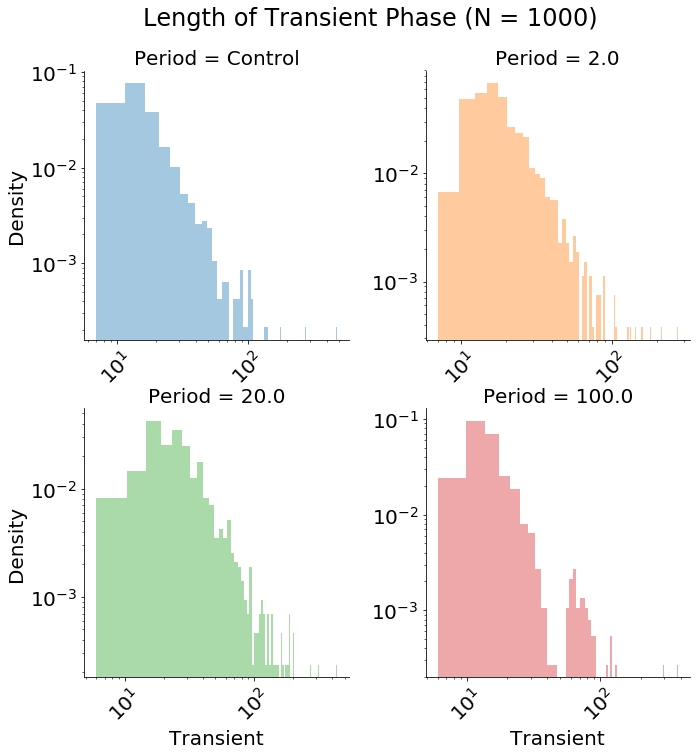

In [12]:
plt.figure(figsize=(20, 10))
# Density distribution of Length of transient
df_insidePeriodCycles = new_df[new_df.InsidePeriodCycles == True]

g = sns.FacetGrid(
    data=df_insidePeriodCycles,
    col="Period",
    hue="Period",
    col_wrap=2,
    sharex=False,
    sharey=False,
    size=5,
)


g = g.map(modified_dist, "Transient", kde=False, norm_hist=True)
g.fig.suptitle("Length of Transient Phase (N = 1000)", y=1.03)
g.fig.tight_layout()
g.set_ylabels("Density")
for i, ax in enumerate(g.fig.axes):  ## getting all axes of the fig object
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yscale("log")
    ax.set_xscale("log")

plt.show()

Same plot with graph that doesn't use the smallest cycle, but rather is dependent upon the period

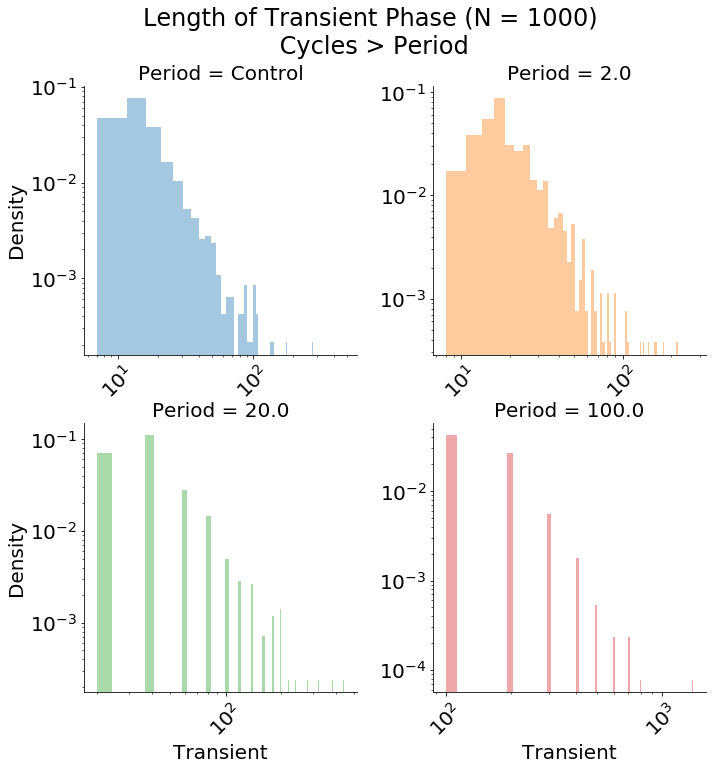

In [13]:
plt.figure(figsize=(20, 10))
# Density distribution of Length of transient
df_insidePeriodCycles = new_df[new_df.InsidePeriodCycles == False]

g = sns.FacetGrid(
    data=df_insidePeriodCycles,
    col="Period",
    hue="Period",
    col_wrap=2,
    sharex=False,
    sharey=False,
    size=5,
)


g = g.map(modified_dist, "Transient", kde=False, norm_hist=True)
g.fig.suptitle("Length of Transient Phase (N = 1000)\n Cycles > Period", y=1.05)
g.fig.tight_layout()
g.set_ylabels("Density")
for i, ax in enumerate(g.fig.axes):  ## getting all axes of the fig object
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yscale("log")
    ax.set_xscale("log")

plt.show()

Same plots for attractor size 

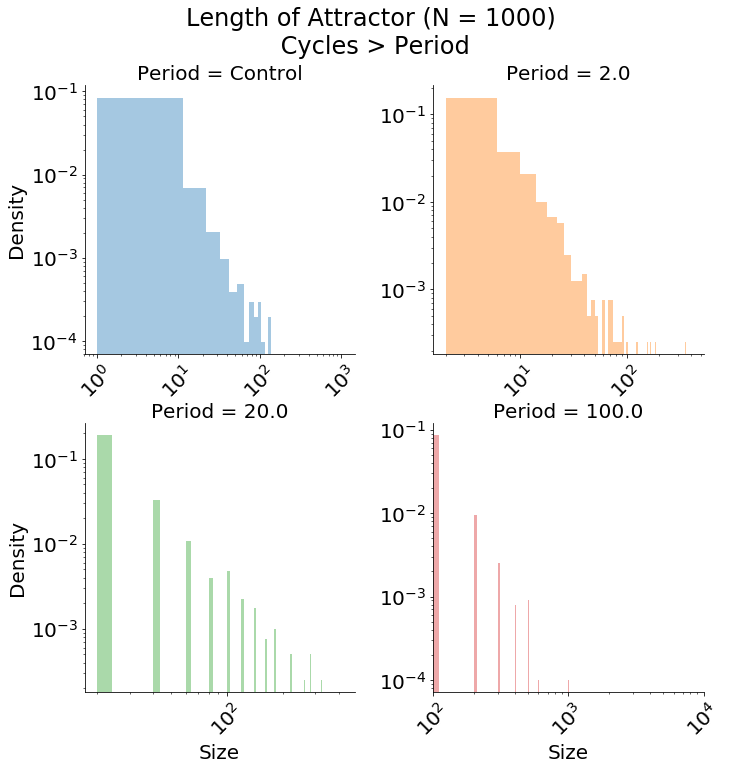

In [14]:
plt.figure(figsize=(20, 10))
# Density distribution of Length of transient
df_insidePeriodCycles = new_df[new_df.InsidePeriodCycles == False]

g = sns.FacetGrid(
    data=df_insidePeriodCycles,
    col="Period",
    hue="Period",
    col_wrap=2,
    sharex=False,
    sharey=False,
    size=5,
)


g = g.map(modified_dist, "Size", kde=False, norm_hist=True)
g.fig.suptitle("Length of Attractor (N = 1000)\n Cycles > Period", y=1.05)
g.fig.tight_layout()
g.set_ylabels("Density")
for i, ax in enumerate(g.fig.axes):  ## getting all axes of the fig object
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yscale("log")
    ax.set_xscale("log")
    if i == 3:
        ax.set_xlim((100, 10000))
#         #print([j.text() for j in ax.get_xticklabels()])
#         print(ax.get_xticks())
#         plt
#         ax.set_xticklabels(ax.get_xticklabels(), rotation= 45)


plt.show()

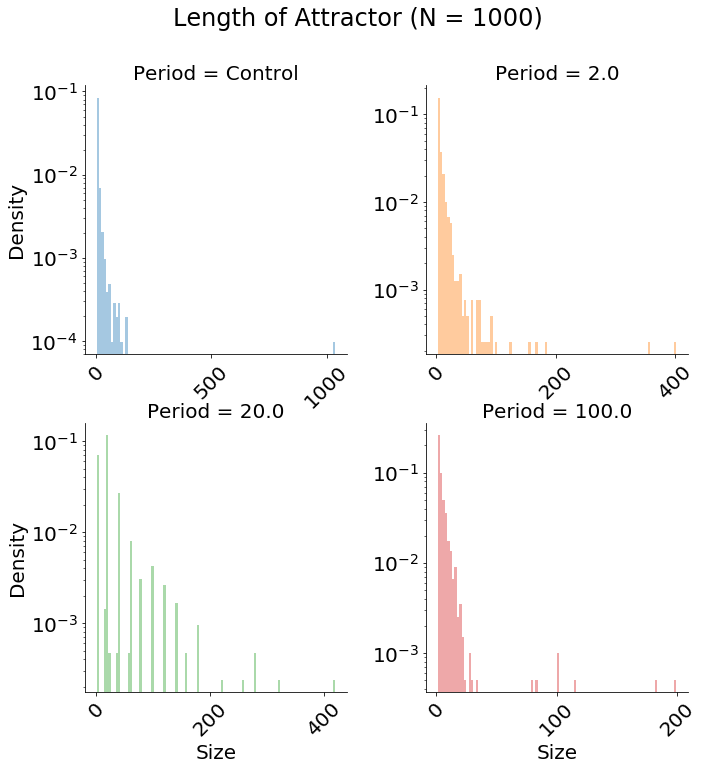

In [15]:
plt.figure(figsize=(20, 10))
# Density distribution of Length of transient
df_insidePeriodCycles = new_df[new_df.InsidePeriodCycles == True]

g = sns.FacetGrid(
    data=df_insidePeriodCycles,
    col="Period",
    hue="Period",
    col_wrap=2,
    sharex=False,
    sharey=False,
    size=5,
)


g = g.map(modified_dist, "Size", kde=False, norm_hist=True)
g.fig.suptitle("Length of Attractor (N = 1000)\n", y=1.05)
g.fig.tight_layout()
g.set_ylabels("Density")
for i, ax in enumerate(g.fig.axes):  ## getting all axes of the fig object
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yscale("log")

plt.show()

In [16]:
test_df = new_df[new_df.InsidePeriodCycles == True]


test_df.groupby("Period").mean()

,Trial,Size,Transient,InsidePeriodCycles
Period,,,,
100.0,499.5,5.020,19.093,True
2.0,499.5,9.160,23.321,True
20.0,499.5,25.029,35.529,True
Control,499.5,7.567,20.383,True


Conclusions: There's a sweet spot of oscillation where you will explore before completing an attractor. If we are at period 100, then we will almost definitely fall onto an attractor and then switch into another function.  

### Now try to characterize the average attractor size and transient length in a network given its oscillatoin

In [17]:
n = 1000
gam = 2.0
my_graph = SFGraph(n, gam)
hub = my_graph.find_hub()
trials = 100
t = 4000

In [18]:
periods = np.arange(2, 100, 8)
attractor_sizes = {per: [] for per in periods}
attractor_trans = {per: [] for per in periods}

In [49]:
for trial in range(trials):
    my_graph.random_config()
    start_config = np.copy(my_graph.get_config())
    for per in periods:
        my_graph.set_config(np.copy(start_config))
        tbl = my_graph.oscillate_update(node_index=hub, period=per, time=t)
        start, stop = Graph.find_attractor_in_oscillations(period=per, state_table=tbl)
        trans = start
        size = stop - start
        attractor_sizes[per].append(size / per)
        attractor_trans[per].append(trans / per)

In [50]:
avg_attractor_sizes = [np.mean(attractor_sizes[key]) for key in attractor_sizes]
avg_attractor_transients = [np.mean(attractor_trans[key]) for key in attractor_trans]

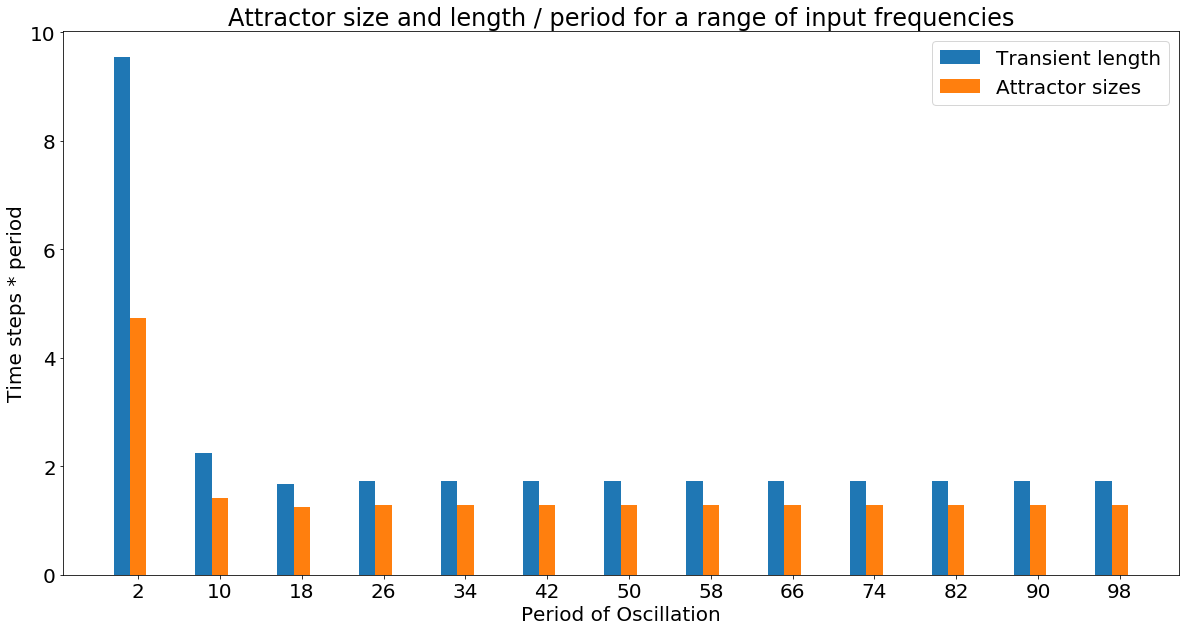

In [72]:
plt.bar(
    range(len(avg_attractor_transients)),
    avg_attractor_transients,
    width=0.2,
    tick_label=periods,
    label="Transient length",
)
plt.bar(
    np.arange(len(avg_attractor_transients)) + 0.2,
    avg_attractor_sizes,
    width=0.2,
    tick_label=periods,
    label="Attractor sizes",
)
plt.xlabel("Period of Oscillation")
plt.title("Attractor size and length / period for a range of input frequencies")
plt.ylabel("Time steps * period")
plt.legend()
plt.show()

# Can we plot to show the visual behind what's happening? 
## Use nxgraph and export to gephi

In [2]:
n = 1000
gam = 2.0

In [3]:
my_graph = SFGraph(n, gam)

In [22]:
oscil_trials = 100
per = 20
oscil_list = []

In [ ]:
n = 1000
gam = 2.0
my_graph = SFGraph(n, gam)
# my_graph = Graph.load_graph(state_file="/Users/Sam/Desktop/n1000gam2_states.npy", graph_file="/Users/Sam/Desktop/n1000gam2_graph.npy")
# Get hub...
hub_node = my_graph.find_hub()

In [ ]:
attr_graph = AttractorGraph(graph=my_graph, oscil_node=hub_node)

In [ ]:
attr_graph.explore_periods(periods=[2], trials=1, t=100)

In [ ]:
attr_graph.export_graph("~/Desktop/test.gexf")

### Calculate average transient length 

In [11]:
96 / 12

8.0

[4.0, 16.0, 26.0, 36.0, 48.0, 58.0, 68.0, 80.0, 90.0, 100.0]

# Separate ON and OFF

In [45]:
import time

In [46]:
gammas = np.linspace(1.7, 3.0, 20)
periods = [i if i % 2 == 0 else i + 1 for i in np.round(np.linspace(4, 100, 6))]
periods
n = 1000
ics = 5
trials = 20
results_list = {per: {gam: [] for gam in gammas} for per in periods}
results_list["0OFF"] = {gam: [] for gam in gammas}
results_list["0ON"] = {gam: [] for gam in gammas}
t1 = time.time()
for gamma in gammas:
    for trial in range(trials):
        my_graph = SFGraph(n, gamma)
        hub = my_graph.find_hub()
        for ic in range(ics):
            my_graph.random_config()
            start_config = np.copy(my_graph.get_config())

            tbl = my_graph.update_return_table_blocked(node=hub, state=1, time=10000)
            attr = Graph.find_attractor(tbl)
            if attr is not None:
                results_list["0ON"][gamma].append(attr)

            my_graph.set_config(np.copy(start_config))
            tbl = my_graph.update_return_table_blocked(node=hub, state=0, time=10000)
            attr = Graph.find_attractor(tbl)
            if attr is not None:
                results_list["0OFF"][gamma].append(attr)

            for per in periods:
                my_graph.set_config(np.copy(start_config))
                tbl = my_graph.oscillate_update(
                    period=per, time=10000, force_start_on=False, node_index=hub
                )
                attr = Graph.find_attractor_in_oscillations(tbl, period=per)
                if attr is not None:
                    results_list[per][gamma].append(attr)

print(t1 - time.time())

-12913.746026039124


In [47]:
transient_dict = {}
size_dict = {}
for p in results_list.keys():
    transient_dict[p] = {}
    size_dict[p] = {}
    for key, vals in results_list[p].items():
        transient_dict[p][key] = np.mean([val[0] for val in vals])
        size_dict[p][key] = np.mean([val[1] - val[0] for val in vals])

In [3]:
import pickle

In [50]:
with open("/Users/Sam/Desktop/transient_length.p", "wb") as fp:
    pickle.dump(file=fp, obj=transient_dict)
with open("/Users/Sam/Desktop/attractor_length.p", "wb") as fp:
    pickle.dump(file=fp, obj=size_dict)

In [7]:
prefix = "/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Oscillating Attractors/AvgAttrs/"

with open(prefix + "transient_length.p", "rb") as fp:
    transient_dict = pickle.load(file=fp)
with open(prefix + "attractor_length.p", "rb") as fp:
    size_dict = pickle.load(file=fp)

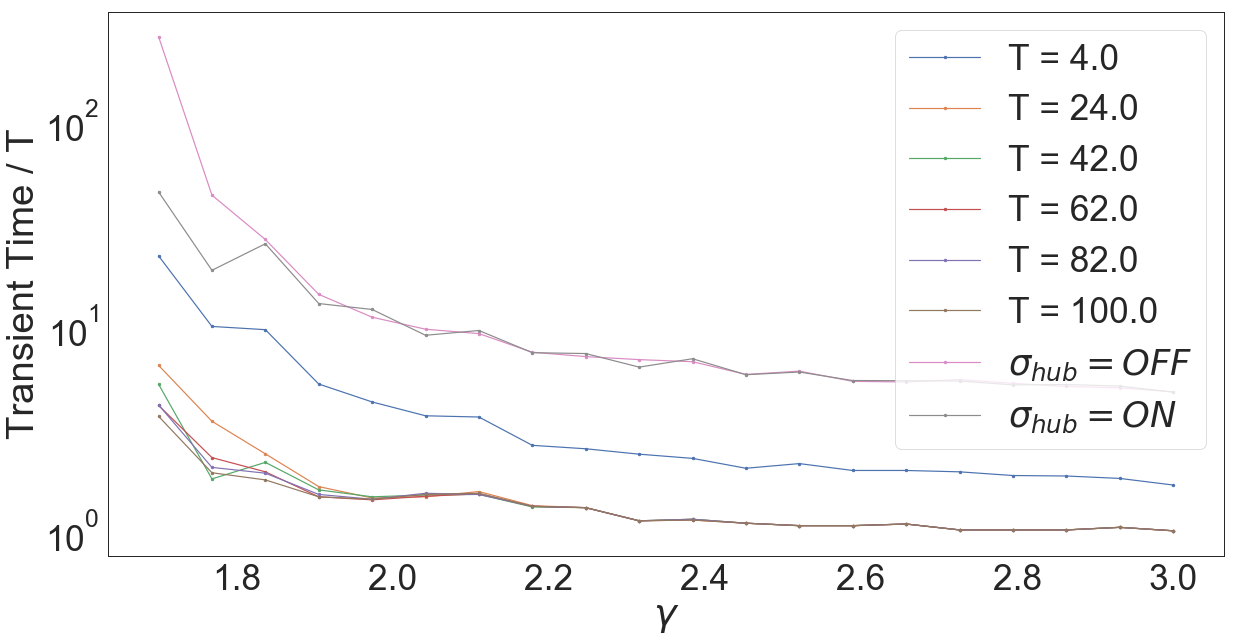

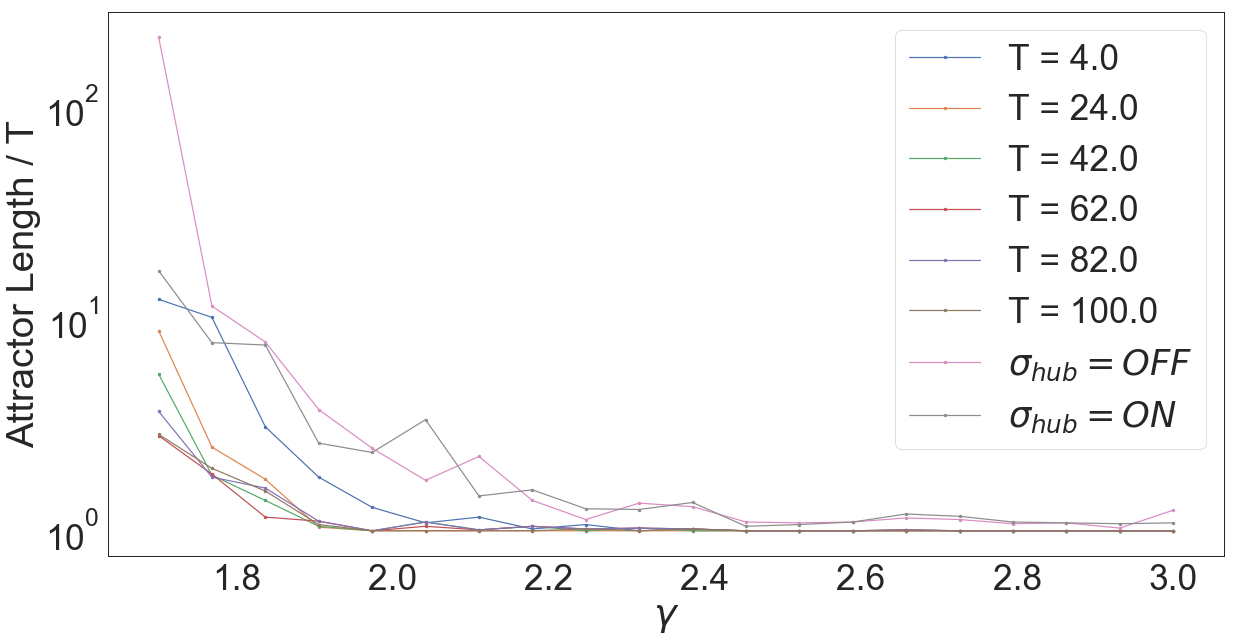

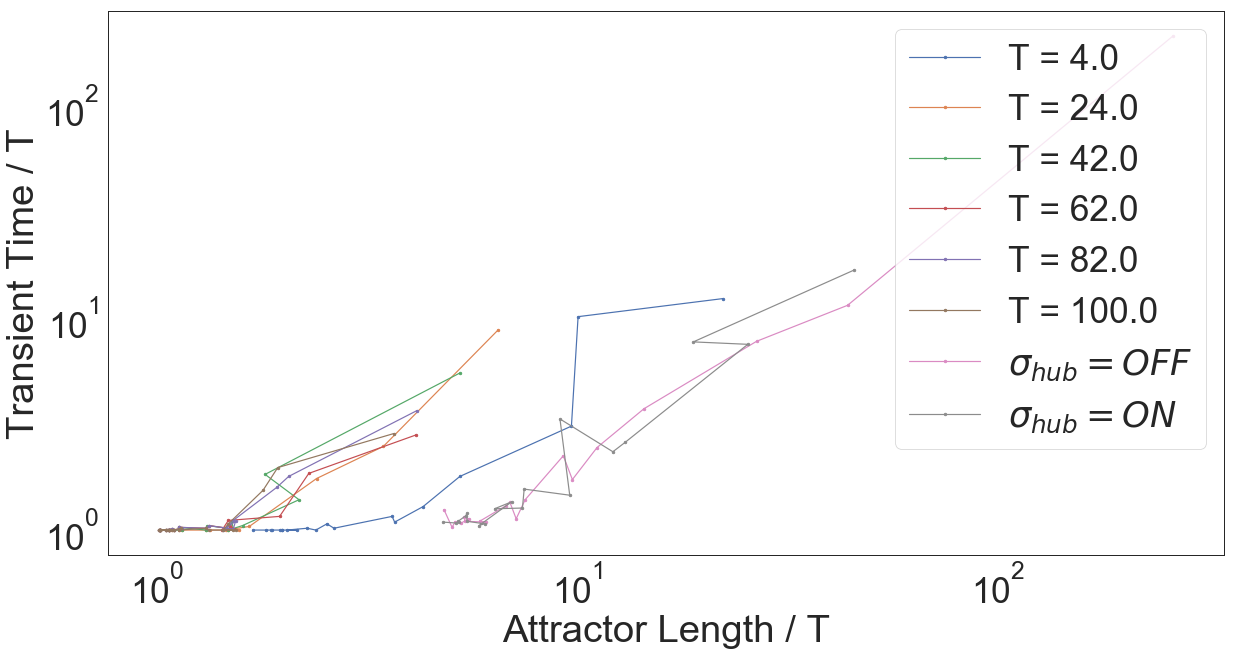

In [8]:
for p in transient_dict.keys():
    if p == "0OFF":
        label = "$\sigma_{hub} = OFF$"
        norm_factor = 1
    elif p == "0ON":
        label = "$\sigma_{hub} = ON$"
        norm_factor = 1
    else:
        label = f"T = {p}"
        norm_factor = int(p)
    plt.plot(
        list(transient_dict[p].keys()),
        np.array(list(transient_dict[p].values())) / norm_factor,
        ".-",
        label=label,
    )
plt.legend()
plt.ylabel("Transient Time / T")
plt.xlabel(r"$\gamma$")
plt.yscale("log")
plt.show()


for p in size_dict.keys():
    if p == "0OFF":
        label = "$\sigma_{hub} = OFF$"
        norm_factor = 1
    elif p == "0ON":
        label = "$\sigma_{hub} = ON$"
        norm_factor = 1
    else:
        label = f"T = {p}"
        norm_factor = int(p)
    plt.plot(
        list(size_dict[p].keys()),
        np.array(list(size_dict[p].values())) / norm_factor,
        ".-",
        label=label,
    )
plt.legend()
plt.ylabel("Attractor Length / T")
plt.xlabel(r"$\gamma$")
plt.yscale("log")
plt.show()


for p in size_dict.keys():
    if p == "0OFF":
        label = "$\sigma_{hub} = OFF$"
        norm_factor = 1
    elif p == "0ON":
        label = "$\sigma_{hub} = ON$"
        norm_factor = 1
    else:
        label = f"T = {p}"
        norm_factor = int(p)
    plt.plot(
        np.array(list(transient_dict[p].values())) / norm_factor,
        np.array(list(size_dict[p].values())) / norm_factor,
        ".-",
        label=label,
    )
plt.legend()
plt.ylabel("Transient Time / T")
plt.xlabel(r"Attractor Length / T")
plt.yscale("log")
plt.xscale("log")
plt.show()